# Pytorch Regression
---
- Author: Marco Sanguineti
- Licence: MIT

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import os

In [2]:
torch.__version__

'1.10.0+cu111'

## Parameters section
---

In [3]:
# Source data path (.xlsx format)
dataset_path = 'dataSet1.xlsx'

# Columns to be removed during analysis
drop_columns = ['x', 'y', 'z' , 'eta_4']

# Number of outputs for the regression problem
n_outputs = 1

# All samples with beta value higher than this threshold are ignored.
beta_threshold = 2*10**3

# Scaling technique
scaler = 'standard' # 1. standard 2. maxmin 3. maxabs  4. None

# Saving path for my best torch model state dictionary and params dictionary
save_path = '/content/results_1/'

# Shuffling data?
shuffle_data = True

# Number of neurons for the layers of the MLP
neurons = [256, 256,]

# Activation function for hidden layers
activation = 'relu' # 1. relu 2. tanh

# Dropout rate
dropout_rate = 0.2

# Learning rate
learning_rate = 10**-4

# Batch size
batch_size = 256

# Training epochs
epochs = 200

# Loss function
loss = 'mse'  # 1. mse # 2. mae

# Optimizer
optimizer_type = 'adam' # 1. adam 2. sgd 3. rmsprop

---

In [4]:
if not os.path.exists(save_path):
  os.mkdir(save_path)

In [5]:
params_dict = {
    'dataset_path': dataset_path,
    'drop_columns': drop_columns,
    'n_outputs': n_outputs,
    'beta_threshold': beta_threshold,
    'scaler': scaler,
    'save_path': save_path,
    'shuffle_data': shuffle_data,
    'neurons': neurons,
    'dropout_rate': dropout_rate,
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'epochs': epochs,
    'loss': loss,
    'optimizer_type': optimizer_type,
}

In [6]:
dataset = pd.read_excel(dataset_path,
                        dtype=np.float32,
                        na_values=['?'])
dataset.head()

,x,y,z,eta_1,eta_2,eta_3,eta_4,eta_5,eta_6,eta_7,beta
0,0.002632,0.09991,0.08889,7074.855957,0.061904,0.00009,3.213112e+11,-0.0,-0.600200,16490.000000,1.121000e+13
1,0.002632,0.09970,0.08889,19415.013672,0.061694,0.00030,1.434694e+10,-0.0,-1.107000,9337.000000,1.266000e+08
2,0.002632,0.09940,0.08889,25530.636719,0.061394,0.00060,1.528335e+09,-0.0,-0.454100,3073.000000,3.450000e+06
3,0.002632,0.09897,0.08889,27847.035156,0.060964,0.00103,2.473389e+08,-0.0,-0.081330,810.099976,9.692000e+05
4,0.002632,0.09837,0.08889,28659.658203,0.060364,0.00163,6.594501e+07,-0.0,-0.001677,186.199997,3.113000e+05


In [7]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
x,25992.0,1.000003e-01,5.771684e-02,2.632000e-03,5.000000e-02,9.998500e-02,1.500000e-01,1.974000e-01
y,25992.0,4.697190e-02,3.062341e-02,8.984000e-05,3.009750e-02,4.010500e-02,7.263000e-02,9.991000e-02
z,25992.0,1.000054e-01,7.171186e-03,8.889000e-02,9.444000e-02,1.000000e-01,1.056000e-01,1.111000e-01
eta_1,25992.0,1.585230e+04,7.653338e+03,1.935201e+03,1.074951e+04,1.709107e+04,1.855130e+04,2.882721e+04
eta_2,25992.0,2.424877e-02,2.074216e-02,1.450000e-04,4.005000e-03,2.036000e-02,3.776444e-02,6.190500e-02
eta_3,25992.0,2.764459e-02,2.114658e-02,8.984000e-05,6.295750e-03,2.849000e-02,4.528750e-02,6.183000e-02
eta_4,25992.0,4.501347e+09,3.662680e+10,1.030580e+06,1.235671e+06,1.433357e+06,4.400288e+06,3.213112e+11
eta_5,25992.0,4.210210e-01,4.933628e-01,-1.428000e-25,-3.125250e-33,-0.000000e+00,1.000000e+00,1.000000e+00
eta_6,25992.0,-3.716199e-05,3.264592e-01,-1.875000e+00,-2.181000e-02,8.844000e-08,4.538750e-02,1.491000e+00
eta_7,25992.0,4.835028e+02,2.167265e+03,1.841000e-01,4.847750e-01,8.178000e+01,1.422750e+02,1.649000e+04


In [8]:
print(f'Original Dataset shape: {dataset.shape}')
if not dataset.isnull().values.any():
  print('No NaN in dataset')
else:
  print('Removing NaN values...\n')
  dataset.dropna(inplace=True)
  print(f'New Dataset shape: {dataset.shape}')

Original Dataset shape: (25992, 11)
No NaN in dataset


In [9]:
print(f'Dropping columns: {drop_columns}\n')
dataset.drop(labels=drop_columns,
             axis=1,
             inplace=True)
dataset.head()

Dropping columns: ['x', 'y', 'z', 'eta_4']



,eta_1,eta_2,eta_3,eta_5,eta_6,eta_7,beta
0,7074.855957,0.061904,0.00009,-0.0,-0.600200,16490.000000,1.121000e+13
1,19415.013672,0.061694,0.00030,-0.0,-1.107000,9337.000000,1.266000e+08
2,25530.636719,0.061394,0.00060,-0.0,-0.454100,3073.000000,3.450000e+06
3,27847.035156,0.060964,0.00103,-0.0,-0.081330,810.099976,9.692000e+05
4,28659.658203,0.060364,0.00163,-0.0,-0.001677,186.199997,3.113000e+05


Checking data distribution... 



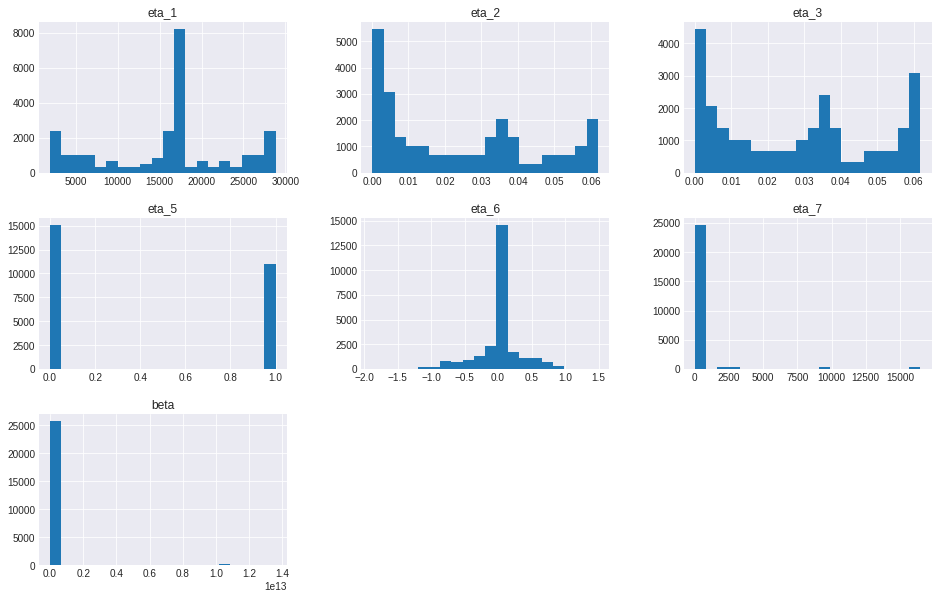

In [10]:
print('Checking data distribution... \n')
plt.style.use('seaborn-darkgrid')
dataset.hist(figsize=(16, 10), bins=20)
plt.show()

In [11]:
print(f'Dropping samples with beta above {beta_threshold}... \n')
print(f'Original shape: {dataset.shape}\n')

dataset = dataset[dataset.beta < beta_threshold]

print(f'New shape: {dataset.shape}\n')

dataset.describe().T

Dropping samples with beta above 2000... 

Original shape: (25992, 7)

New shape: (16549, 7)



,count,mean,std,min,25%,50%,75%,max
eta_1,16549.0,17125.681641,5303.111328,2.194923e+03,1.660482e+04,1.725853e+04,17338.337891,28190.968750
eta_2,16549.0,0.022294,0.016571,1.460000e-04,7.244000e-03,1.986400e-02,0.034799,0.056615
eta_3,16549.0,0.027306,0.015978,1.742000e-03,1.279000e-02,2.880000e-02,0.036920,0.061160
eta_5,16549.0,0.516707,0.499765,-5.255000e-29,-5.016000e-35,1.000000e+00,1.000000,1.000000
eta_6,16549.0,-0.000109,0.376262,-1.295000e+00,-4.540000e-06,6.666000e-08,0.000008,0.997900
eta_7,16549.0,53.818039,57.671818,1.841000e-01,2.266000e-01,4.924000e+00,103.400002,177.100006
beta,16549.0,295.904175,418.340027,1.262000e-03,1.747000e+01,1.258000e+02,370.500000,1998.000000


Checking data distribution... 



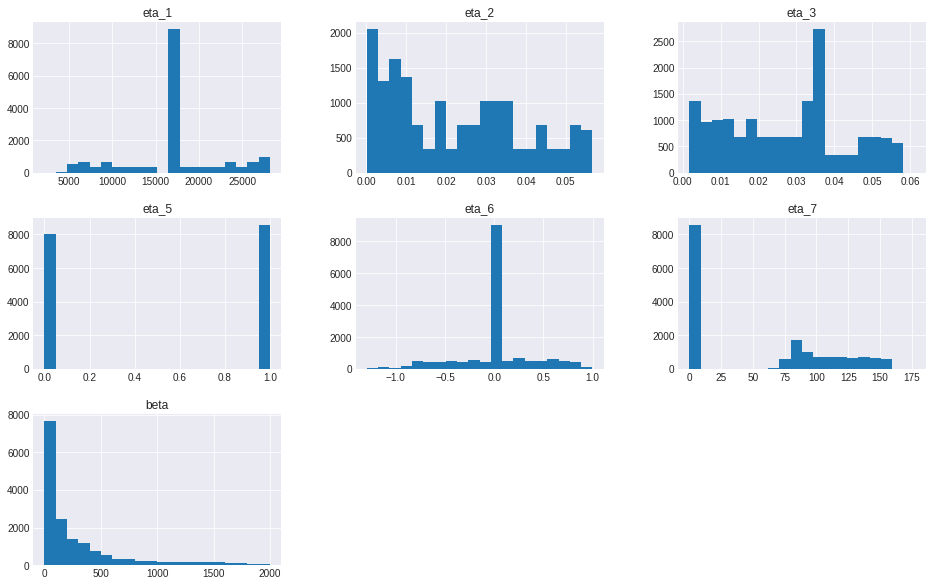

In [12]:
print('Checking data distribution... \n')
plt.style.use('seaborn-darkgrid')
dataset.hist(figsize=(16, 10), bins=20)
plt.show()

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split

In [14]:
def scale(df: pd.DataFrame,
          scaler: str = 'standard') -> pd.DataFrame:
  if scaler == 'standard':
    scaler = StandardScaler()
  elif scaler == 'maxmin':
    scaler = MinMaxScaler()
  elif scaler == 'maxabs':
    scaler = MaxAbsScaler()
  else:
    return df

  scaler.fit(df)
  return pd.DataFrame(scaler.transform(df), columns=df.columns), scaler

In [15]:
print(f'scaling dataset with the chosen scaler: {scaler}\n')
normed_dataset, my_scaler = scale(dataset, scaler)
normed_dataset.describe().T

scaling dataset with the chosen scaler: standard



,count,mean,std,min,25%,50%,75%,max
eta_1,16549.0,-2.822387e-09,1.000024,-2.815500,-0.098212,0.025057,0.040108,2.086598
eta_2,16549.0,-7.849271e-07,1.000030,-1.336567,-0.908219,-0.146631,0.754663,2.071209
eta_3,16549.0,-2.029461e-06,1.000048,-1.599928,-0.908472,0.093539,0.601742,2.118840
eta_5,16549.0,-6.470880e-06,1.000104,-1.033993,-1.033993,0.967128,0.967128,0.967128
eta_6,16549.0,-1.706324e-07,1.000029,-3.441569,0.000279,0.000291,0.000313,2.652517
eta_7,16549.0,-5.908946e-06,1.000024,-0.930087,-0.929350,-0.847896,0.859708,2.137689
beta,16549.0,1.662260e-07,1.000029,-0.707350,-0.665591,-0.406632,0.178317,4.068812


In [16]:
print(f'Splitting data in 3 dataset for training - validation - test... (shuffle: {shuffle_data})\n')

if shuffle_data:
  train, validate, test = np.split(normed_dataset.sample(frac=1, random_state=22), 
                                  [int(.6*len(normed_dataset)), int(.8*len(normed_dataset))])
else:
    train, validate, test = np.split(normed_dataset, 
                                  [int(.6*len(normed_dataset)), int(.8*len(normed_dataset))])

print(f'Train shape: {train.shape}')
print(f'Validate shape: {validate.shape}')
print(f'Test shape: {test.shape}')

Splitting data in 3 dataset for training - validation - test... (shuffle: True)

Train shape: (9929, 7)
Validate shape: (3310, 7)
Test shape: (3310, 7)


In [17]:
import torch.nn as nn
import torch

class RegNet1D(nn.Module):
    def __init__(self,
                 num_feature: int = 10,
                 num_class: int = 1,
                 dropout_rate: float = 0.0,
                 neurons: list = [64, 32,],
                 activation: str = 'relu') -> None:
        
        super(RegNet1D, self).__init__()

        self.fc1 = nn.Linear(num_feature, neurons[0])
        self.fc2 = nn.Linear(neurons[0], neurons[1])

        self.layer_out = nn.Linear(neurons[1], num_class)

        if activation == 'relu':
          self.act = nn.ReLU()
        elif activation == 'tanh':
          self.act = nn.Tanh()
        else:
          self.act = nn.ReLU()

        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn1 = nn.BatchNorm1d(neurons[0])
        self.bn2 = nn.BatchNorm1d(neurons[1])

    def forward(self, x) -> torch.Tensor:
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.dropout(x)

        x = self.layer_out(x)

        return x

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'working on {device}')

working on cuda:0


In [19]:
model = RegNet1D(
    num_feature=train.shape[1] - n_outputs,
    num_class=1,
    neurons=neurons,
    dropout_rate=dropout_rate,
    activation=activation
    ).to(device)
model

RegNet1D(
  (fc1): Linear(in_features=6, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (layer_out): Linear(in_features=256, out_features=1, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [20]:
import torchsummary
torchsummary.summary(model, (train.shape[1] - n_outputs,), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [256, 256]           1,792
       BatchNorm1d-2                 [256, 256]             512
              ReLU-3                 [256, 256]               0
           Dropout-4                 [256, 256]               0
            Linear-5                 [256, 256]          65,792
       BatchNorm1d-6                 [256, 256]             512
              ReLU-7                 [256, 256]               0
           Dropout-8                 [256, 256]               0
            Linear-9                   [256, 1]             257
Total params: 68,865
Trainable params: 68,865
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 4.00
Params size (MB): 0.26
Estimated Total Size (MB): 4.27
---------------------------------------------

In [21]:
print(f'Loss function: {loss}\n')
if loss == 'mse':
  criterion = nn.MSELoss()
elif loss == 'mae':
  criterion = nn.L1Loss()
else:
  criterion = nn.MSELoss()

Loss function: mse



In [22]:
print(f'optimizer: {optimizer_type}\n')

if optimizer_type == 'adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_type == 'sgd':
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
elif optimizer_type == 'rmsprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
else:
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

optimizer: adam



In [23]:
class CustomLogger(object):
    def __init__(self):
        self.accuracy = {
            'train': [],
            'val': []
        }
        self.loss = {
            'train': [],
            'val': []
        }

In [24]:
n_inputs = train.shape[1] - n_outputs

X_train = train.to_numpy()[:, :n_inputs]
X_val = validate.to_numpy()[:, :n_inputs]
X_test = test.to_numpy()[:, :n_inputs]

y_train = train.to_numpy()[:, n_inputs:n_inputs + n_outputs]
y_val = validate.to_numpy()[:, n_inputs:n_inputs + n_outputs]
y_test = test.to_numpy()[:, n_inputs:n_inputs + n_outputs]

In [25]:
from torch.utils.data import Dataset, DataLoader

class RegressionDataset(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())

In [26]:
from sklearn.metrics import r2_score
import copy

print("Starting Training...\n")

Logger = CustomLogger()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_data, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle_data, drop_last=True)

model.train()
best_model = None
best_acc = -1000

for epoch in range(0, epochs):
    train_epoch_loss = 0
    train_epoch_acc = 0
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device).view(-1, 1)

        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        
        train_acc = r2_score(y_train_pred.cpu().detach().numpy(),
                             y_train_batch.cpu().detach().numpy())

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    with torch.no_grad():

        val_epoch_loss = 0
        val_epoch_acc = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device).view(-1, 1)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = r2_score(y_val_pred.cpu().detach().numpy(),
                               y_val_batch.cpu().detach().numpy())

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    Logger.loss['train'].append(train_epoch_loss/len(train_loader))
    Logger.loss['val'].append(val_epoch_loss/len(val_loader))
    Logger.accuracy['train'].append(train_epoch_acc/len(train_loader))
    Logger.accuracy['val'].append(val_epoch_acc/len(val_loader))

    print(f'Epoch {epoch+1+0:04}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(val_loader):.3f} |')
    
    if val_epoch_acc > best_acc:
        print('Saving a new best model')
        best_model = copy.deepcopy(model)
        best_acc = val_epoch_acc

Starting Training...

Epoch 0001: | Train Loss: 0.69544 | Val Loss: 0.50979 | Train Acc: -1.457 | Val Acc: -0.269 |
Saving a new best model
Epoch 0002: | Train Loss: 0.47343 | Val Loss: 0.45785 | Train Acc: 0.001 | Val Acc: 0.100 |
Saving a new best model
Epoch 0003: | Train Loss: 0.44259 | Val Loss: 0.43559 | Train Acc: 0.112 | Val Acc: 0.207 |
Saving a new best model
Epoch 0004: | Train Loss: 0.43057 | Val Loss: 0.42752 | Train Acc: 0.166 | Val Acc: 0.215 |
Saving a new best model
Epoch 0005: | Train Loss: 0.41781 | Val Loss: 0.40542 | Train Acc: 0.204 | Val Acc: 0.246 |
Saving a new best model
Epoch 0006: | Train Loss: 0.40706 | Val Loss: 0.40061 | Train Acc: 0.249 | Val Acc: 0.240 |
Epoch 0007: | Train Loss: 0.39860 | Val Loss: 0.40591 | Train Acc: 0.264 | Val Acc: 0.333 |
Saving a new best model
Epoch 0008: | Train Loss: 0.39155 | Val Loss: 0.39418 | Train Acc: 0.289 | Val Acc: 0.309 |
Epoch 0009: | Train Loss: 0.38335 | Val Loss: 0.38263 | Train Acc: 0.315 | Val Acc: 0.284 |
Epoc

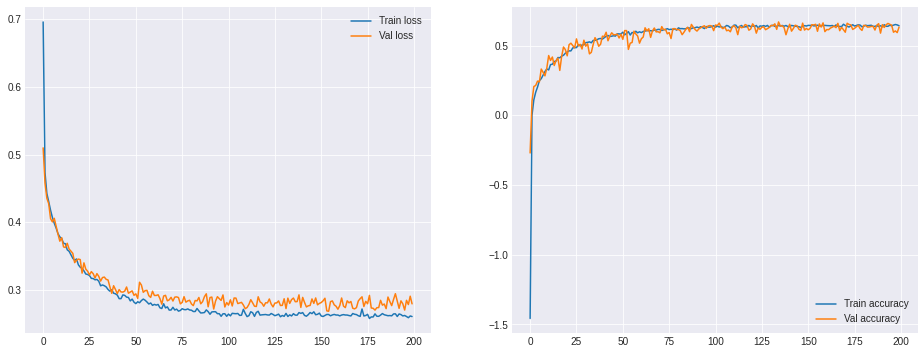

In [27]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
axs[0].plot(Logger.loss['train'], label='Train loss')
axs[0].plot(Logger.loss['val'], label='Val loss')
axs[0].legend()
axs[1].plot(Logger.accuracy['train'], label='Train accuracy')
axs[1].plot(Logger.accuracy['val'], label='Val accuracy')
axs[1].legend()
plt.show()

In [28]:
print('Saving best model to file... \n')
model = best_model
torch.save(model.state_dict(), os.path.join(save_path, 'best_model.pth'))

Saving best model to file... 



In [29]:
print('Saving my simulation parameters...\n')
import json
with open(os.path.join(save_path, 'params.json'), 'w') as fp:
    json.dump(params_dict, fp)

Saving my simulation parameters...



In [30]:
model.eval()

RegNet1D(
  (fc1): Linear(in_features=6, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (layer_out): Linear(in_features=256, out_features=1, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [31]:
print('Making predictions...')
train_preds = model(torch.Tensor(X_train).to(device)).cpu().detach().numpy()
val_preds = model(torch.Tensor(X_val).to(device)).cpu().detach().numpy()
test_preds = model(torch.Tensor(X_test).to(device)).cpu().detach().numpy()

Making predictions...


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def results_log(_t, _p, set:str = ''):
  print(f'Dataset: {set} - mae: {mean_absolute_error(_t, _p)} - mse: {mean_squared_error(_t, _p)} - r2: {r2_score(_t, _p)}\n')

In [33]:
results_log(train_preds, y_train, 'train')
results_log(val_preds, y_val, 'val')
results_log(test_preds, y_test, 'test')

Dataset: train - mae: 0.2767840027809143 - mse: 0.26786383986473083 - r2: 0.6847108061204681

Dataset: val - mae: 0.27943798899650574 - mse: 0.28814539313316345 - r2: 0.6679943871818093

Dataset: test - mae: 0.2955712676048279 - mse: 0.2996906638145447 - r2: 0.6505611434383591



In [34]:
print('Reloading parameters if needed...')
with open(os.path.join(save_path, 'params.json')) as f:
  params = json.load(f)
params

Reloading parameters if needed...


{'batch_size': 256,
 'beta_threshold': 2000,
 'dataset_path': 'dataSet1.xlsx',
 'drop_columns': ['x', 'y', 'z', 'eta_4'],
 'dropout_rate': 0.2,
 'epochs': 200,
 'learning_rate': 0.0001,
 'loss': 'mse',
 'n_outputs': 1,
 'neurons': [256, 256],
 'optimizer_type': 'adam',
 'save_path': '/content/results_1/',
 'scaler': 'standard',
 'shuffle_data': True}

In [35]:
print('reloading a torch model for inference...\n')
reloaded_model = RegNet1D(
                          num_feature=train.shape[1] - n_outputs,
                          num_class=1,
                          neurons=neurons,
                          dropout_rate=dropout_rate
                          ).to(device)

reloaded_model.load_state_dict(torch.load(os.path.join(save_path, 'best_model.pth')))
reloaded_model.eval()
reloaded_model

reloading a torch model for inference...



RegNet1D(
  (fc1): Linear(in_features=6, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (layer_out): Linear(in_features=256, out_features=1, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [36]:
# %%shell
# jupyter nbconvert --to html torch_regression_workflow.ipynb